In [23]:
import torch
import csv
import numpy as np
#%matplotlib ipympl
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import torch
from torch.optim import Adam
from torch.optim import SGD
import torch.nn as nn
from scipy import io

plt.ion()

In [24]:
filename = "simple-data.txt" # replace with your file name

material_names_to_ids = {}
coefficient_data = []

num_materials = 0
with open(filename, 'r') as file:
    reader = csv.reader(file, delimiter='\t')
    for row in reader:
        def get_id(name):
            global num_materials
            if name not in material_names_to_ids:
                material_names_to_ids[name] = num_materials
                num_materials = num_materials+1
            return material_names_to_ids[name]
        coefficient_data.append((get_id(row[0]),get_id(row[1]),float(row[2])))

In [25]:
# extract the row indices, column indices, and values from the triplets
rows = [t[0] for t in coefficient_data]
cols = [t[1] for t in coefficient_data]
vals = [t[2] for t in coefficient_data]
# create a sparse matrix in COO format
coefficient_matrix = coo_matrix((vals, (rows, cols)),shape=(num_materials,num_materials))

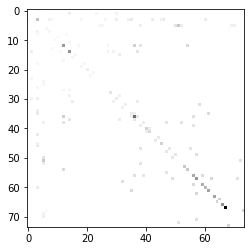

In [26]:
# plot the sparsity pattern
plt.imshow((coefficient_matrix+coefficient_matrix.T).todense(), cmap='binary', interpolation='nearest')
plt.show()

In [238]:
# define the initial values of z[i] and z[j]
log_z = torch.randn(num_materials, 1, requires_grad=True)

In [239]:
# define the optimizer
optimizer = Adam([log_z], lr=0.1)# define the loss function
#optimizer = SGD([log_z], lr=0.01, momentum=0.9)

In [240]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        w = 20
        self.layer1 = nn.Linear(2, w)
        self.layer2 = nn.Linear(w, w)
        self.layer3 = nn.Linear(w, w)
        self.layer4 = nn.Linear(w, w)
        self.layer5 = nn.Linear(w, w)
        self.layer6 = nn.Linear(w, w)
        #self.layer4 = nn.Linear(20, 20)
        self.last_layer = nn.Linear(w, 1)
        self.relu = nn.ReLU() # ReLU activation function

    def forward(self, zi, zj):
        # THIS DOES NOT WORK
        #x = torch.tensor([zi,zj],requires_grad=True)
        # YOU HAVE TO DO THIS?! DUH!
        x = torch.stack([zi, zj]).T
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        #x = self.relu(self.layer4(x))
        #x = self.relu(self.layer5(x))
        #x = self.relu(self.layer6(x))
        x = self.last_layer(x)
        return x
        #return torch.sqrt(x[0]*x[1])

In [241]:
def geomean(zi,zj):
    return torch.sqrt(zi * zj)

model = SimpleNet()

def f(zi,zj):
    return model.forward(zi,zj)
    #return geomean(zi,zj)

def loss_function(triplets, log_z):
    loss = 0
    z = torch.exp(log_z)
    for i, j, v in triplets:
        loss += ( f(z[i],z[j]) - v)**2
    return loss

In [ ]:
# perform the optimization
num_epochs = 200000
batch_size = 16
#batch_size = len(coefficient_data)
for epoch in range(num_epochs):
    if epoch % 100 == 0:
        print(f"%d: %g (%g,%g)" % (epoch,loss_function(coefficient_data,log_z)/len(coefficient_data),torch.min(log_z),torch.max(log_z)))
    # shuffle the triplets for each epoch
    np.random.shuffle(coefficient_data)
    # iterate over mini-batches
    #for i in [1]:
    for i in range(0, len(coefficient_data), batch_size):
        batch_triplets = coefficient_data[i:i+batch_size]
        optimizer.zero_grad()
        loss = loss_function(batch_triplets, log_z)
        loss.backward()
        optimizer.step()    
    
# print the final values of z
#print(torch.exp(log_z).detach().numpy())

0: 0.248747 (-2.86979,2.58092)
100: 0.0121741 (-7.38425,4.36309)
200: 0.0121876 (-8.50412,4.3091)
300: 0.0119968 (-9.20793,4.47573)
400: 0.0119664 (-9.75196,4.47574)
500: 0.0120298 (-10.2084,4.46641)
600: 0.0121096 (-10.6181,4.38121)
700: 0.0120882 (-10.997,4.73623)
800: 0.0121226 (-11.3551,4.73549)
900: 0.012041 (-11.6975,4.73549)
1000: 0.0122418 (-12.0218,4.73549)
1100: 0.0121689 (-12.3404,4.73549)
1200: 0.0140515 (-12.6507,4.73549)
1300: 0.0125956 (-12.9641,4.73549)
1400: 0.0125566 (-13.269,4.73549)
1500: 0.0127358 (-13.5763,4.73549)
1600: 0.0126163 (-13.8745,4.73549)
1700: 0.0129758 (-14.1755,4.73549)
1800: 0.0124426 (-14.4743,4.73549)
1900: 0.0124315 (-14.7709,4.73549)
2000: 0.0128386 (-15.0645,4.73549)
2100: 0.0125249 (-15.3567,4.73549)
2200: 0.0125714 (-15.6487,4.73549)
2300: 0.0125903 (-15.9346,4.73549)
2400: 0.0124712 (-16.2107,4.73549)
2500: 0.0126168 (-16.4867,4.73549)
2600: 0.0125649 (-16.7545,4.73549)
2700: 0.0126164 (-17.013,4.73549)
2800: 0.0124125 (-17.258,4.73549)
2900

In [ ]:
def write_to_data_mat(log_z):
    global coefficient_data
    indices = np.array([(i, j) for (i, j, v) in coefficient_data])
    values = np.array([v for (i, j, v) in coefficient_data])
    # extract the coordinates from z using the indices
    io.savemat('data.mat', {'z': torch.exp(log_z).detach().numpy(),'indices': indices, 'values': values})

In [104]:
write_to_data_mat(log_z)

In [10]:
import sys

print(sys.executable)

/Users/alecjacobson/miniconda3/bin/python


In [12]:
print(sys.version)

3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
